In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pymc3 as pm
import scipy.stats as stats
import seaborn as sns
import pandas as pd

from scipy import stats
# logistic (or inverse-logit) is the inverse of the logit function
from scipy.special import expit as logistic

import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)

from causalgraphicalmodels import CausalGraphicalModel
import daft

This is based on the [homework of week 6](https://github.com/rmcelreath/statrethinking_winter2019/blob/master/homework/week06.pdf) of Statistical Rethinking book material.
I do the homework based on the questions but not following a specific order.
<br>
<br>
The dataset can be found [here](https://github.com/rmcelreath/rethinking/blob/Experimental/data/)
<br>
<br>
"The data in NWOGrants are outcomes for scientific funding applications for the Netherlands Organization for Scientific Research (NWO) from 2010-2012 (see van der Lee and Ellemers doi:10.1073/pnas.1510159112)."

In [2]:
df = pd.read_csv('../data/NWOGrants.csv', sep=';')

# create categories for gender and discipline as it'll be required
# female = 1
# male = 0
df['gender_id'] = (df['gender']=='f').astype(int)
df['discipline_id'] = df['discipline'].astype('category').cat.codes
df

,discipline,gender,applications,awards,gender_id,discipline_id
0,Chemical sciences,m,83,22,0,0
1,Chemical sciences,f,39,10,1,0
2,Physical sciences,m,135,26,0,5
3,Physical sciences,f,39,9,1,5
4,Physics,m,67,18,0,6
5,Physics,f,9,2,1,6
6,Humanities,m,230,33,0,2
7,Humanities,f,166,32,1,2
8,Technical sciences,m,189,30,0,8
9,Technical sciences,f,62,13,1,8


## Effects of gender on grant awards
Total and indirect causal effects of gender on grant awards.

The Generalized Linear Model (GLM) we will use is the *Aggregated Binomial Regression*. It uses *Binomial Probability* functions. We'll do so because the values a aggregated and the outcome can take the value 0 or any positive integer up to n (the number of trials).
<br>
<br>
The Binomial distribution is used to count events, in a case where  we know the number of trials.
<br>
<br>
Different from the Normal distribution, neither of the 2 parameters of the Binomial distribution represents the mean, therefore, we need a **Link Function**. For the case of the Binomial distribution this link function is the **Logit Link**, it maps the parameter as a probability mass by constraining it to lie between zero and one.

In [3]:
with pm.Model() as m1:
    a = pm.Normal('a', 0, 1.5, shape=len(df.gender_id.unique()))
    p = pm.math.invlogit(a[df.gender_id])
    
    awards = pm.Binomial('awards', n=df.applications, p=p, observed=df.awards)
    m1_trace = pm.sample()
    
    m1_data = az.from_pymc3(m1_trace)
    m1_prior = az.from_pymc3(prior=pm.sample_prior_predictive())
    m1_post_pred = pm.sample_posterior_predictive(m1_trace)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


array([[<AxesSubplot:title={'center':'a\n0'}>,
        <AxesSubplot:title={'center':'a\n0'}>],
       [<AxesSubplot:title={'center':'a\n1'}>,
        <AxesSubplot:title={'center':'a\n1'}>]], dtype=object)

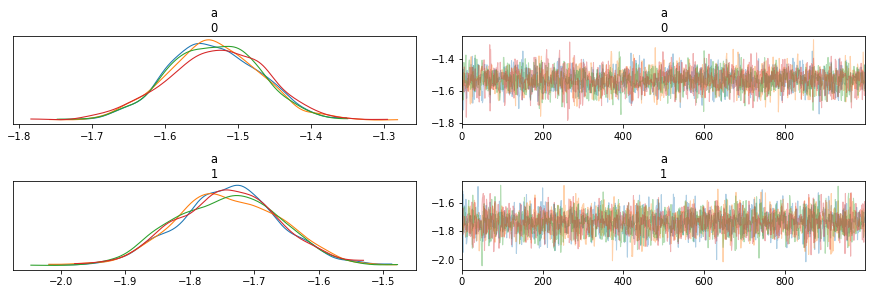

In [4]:
az.plot_trace(m1_trace)

All chains seem healthy as they all look like "hairy caterpillars".

array([[<AxesSubplot:title={'center':'a'}>]], dtype=object)

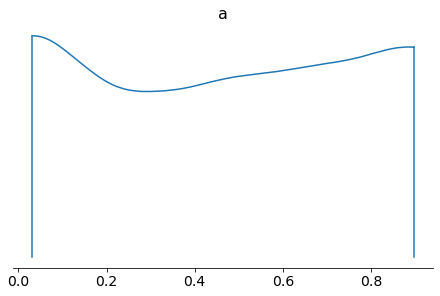

In [5]:
az.plot_density([logistic(m1_prior.prior.sel(a_dim_0=0))],
                var_names=["a"],
                group="prior",
                point_estimate=None,
               )

Observing the prior posterior predictive plot above, we can see it gives each gender a somehow equal probability between 0 and 100% of being more related to awards. 
<br>
<br>
It's important to observe that: "A flat prior in the logit space is not a flat prior in the outcome probability space."
<br>
That's why it's fundamental to plot it and see if it looks reasonable.

In [6]:
az.summary(m1_trace, round_to=2, kind="stats")

,mean,sd,hdi_3%,hdi_97%
a[0],-1.53,0.06,-1.66,-1.42
a[1],-1.74,0.08,-1.88,-1.59


array([<AxesSubplot:title={'center':'94.0% HDI'}>], dtype=object)

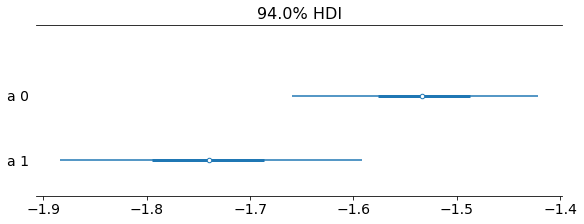

In [7]:
az.plot_forest([m1_trace], 
              var_names=["a"],
              combined=True,
              figsize=(8,3))

By the forest plot above we can see clearly that there's a total direct effect on grant awards is greater if the gender is masculiine **a0**.

In [8]:
m1_diff_a = m1_data.posterior['a'].sel(a_dim_0=0) - m1_data.posterior['a'].sel(a_dim_0=1)
m1_diff_p = logistic(m1_data.posterior['a'].sel(a_dim_0=0)) - logistic(m1_data.posterior['a'].sel(a_dim_0=1))

az.summary({"diff_a": m1_diff_a, "diff_p": m1_diff_p})

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
diff_a,0.208,0.102,0.014,0.395,0.002,0.001,3854.0,3549.0,3850.0,2814.0,1.0
diff_p,0.028,0.014,0.002,0.053,0.000,0.000,3850.0,3563.0,3841.0,2834.0,1.0


We are exploring 2 ways of contrasting predictions:
* **diff_a** are the **Absolute Effects**, the difference a counter-factual change in a variable might make on an absolute scale of measurement. "How much difference does the gender make on being awarded a grant?". In our case we can see that there's on average 21% probability of being awarded a grant if you're male.

* **diff_p** are the **Relative Effects** that are the proportional changes in the odds of an outcome. These **Proportional Odds** show that the difference is somewhere between 1.5 and 4.3%.  

In [9]:
df['m1_pred'] = m1_post_pred['awards'].mean(0)

[]

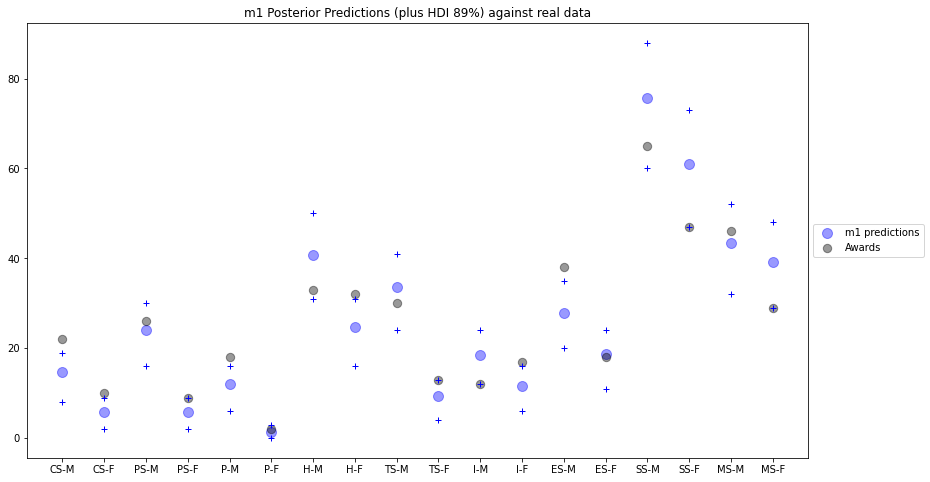

In [10]:
x_axis = np.linspace(0, 17, 18)

_, ax = plt.subplots(figsize=(14,8))
ax.scatter(x_axis, df.m1_pred, c='b', s=100, alpha=0.4, label='m1 predictions')
ax.scatter(x_axis, df.awards, c='k', s=70, alpha=0.4, label='Awards')
ax.plot([range(0,18), range(0,18)], az.hdi(m1_post_pred['awards'], hdi_prob=.89).T, 'b+')

plt.title('m1 Posterior Predictions (plus HDI 89%) against real data')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

ax.set_xticks(x_axis) 
ax.set_xticklabels(('CS-M', 'CS-F', 'PS-M', 'PS-F', 'P-M', 'P-F', 'H-M', 'H-F', 
                    'TS-M', 'TS-F', 'I-M', 'I-F', 'ES-M', 'ES-F', 'SS-M', 'SS-F', 
                    'MS-M', 'MS-F'))
plt.plot()

The plot above is the posterior check of the predictions against the real data. The **High Density Interval** (HDI) of 89% for the predictions, bounded by the "+", is also included. Notice that some of real data falls out of this interval.

Now, for our causal model, let's consider a mediation path (a pipe) through disciplines.

In [11]:
with pm.Model() as m2:
    a = pm.Normal('a', 0, 1.5, shape=len(df.gender_id.unique()))
    b = pm.Normal('b', 0, 1.5, shape=len(df.discipline_id.unique()))
    
    p = pm.math.invlogit(a[df.gender_id] + b[df.discipline_id])
    
    awards = pm.Binomial('awards', n=df.applications, p=p, observed=df.awards) 
    
    m2_trace = pm.sample(2000)
    m2_data = az.from_pymc3(m2_trace)
    m2_post_pred = pm.sample_posterior_predictive(m2_trace)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 6 seconds.
The number of effective samples is smaller than 10% for some parameters.


array([[<AxesSubplot:title={'center':'a\n0'}>,
        <AxesSubplot:title={'center':'a\n0'}>],
       [<AxesSubplot:title={'center':'a\n1'}>,
        <AxesSubplot:title={'center':'a\n1'}>],
       [<AxesSubplot:title={'center':'b\n0'}>,
        <AxesSubplot:title={'center':'b\n0'}>],
       [<AxesSubplot:title={'center':'b\n1'}>,
        <AxesSubplot:title={'center':'b\n1'}>],
       [<AxesSubplot:title={'center':'b\n2'}>,
        <AxesSubplot:title={'center':'b\n2'}>],
       [<AxesSubplot:title={'center':'b\n3'}>,
        <AxesSubplot:title={'center':'b\n3'}>],
       [<AxesSubplot:title={'center':'b\n4'}>,
        <AxesSubplot:title={'center':'b\n4'}>],
       [<AxesSubplot:title={'center':'b\n5'}>,
        <AxesSubplot:title={'center':'b\n5'}>],
       [<AxesSubplot:title={'center':'b\n6'}>,
        <AxesSubplot:title={'center':'b\n6'}>],
       [<AxesSubplot:title={'center':'b\n7'}>,
        <AxesSubplot:title={'center':'b\n7'}>],
       [<AxesSubplot:title={'center':'b\n8'}>,
   

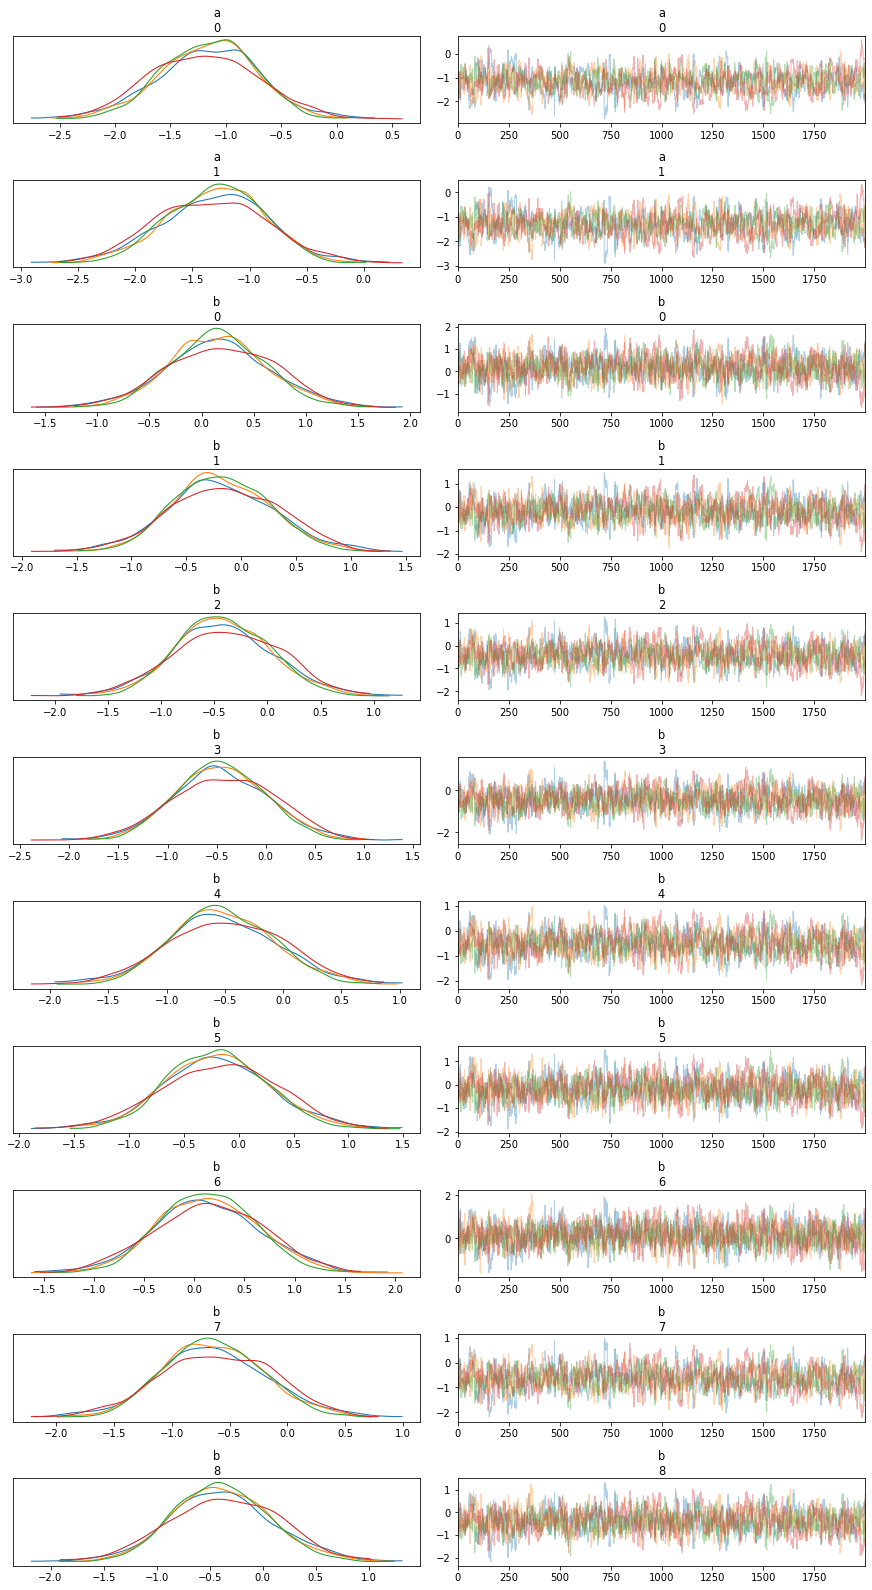

In [12]:
az.plot_trace(m2_trace)

All chains seem healthy as they all look like "hairy caterpillars".
<br>
<br>
The model didn't sample very well probably because it's over-parameterized, one of the parameters **a** is not necessary, but that's ok as this way it makes it easier to assign priors. Besides "it isn't a violation of any statistical principle. The only limitation is whether the algorithm we used to approximate the posterior can handle the high correlations. In this case, it can."

In [13]:
az.summary(m2_trace, round_to=2, kind="stats")

,mean,sd,hdi_3%,hdi_97%
a[0],-1.17,0.45,-2.03,-0.33
a[1],-1.31,0.46,-2.19,-0.50
b[0],0.17,0.49,-0.75,1.10
b[1],-0.17,0.47,-1.03,0.73
b[2],-0.41,0.47,-1.29,0.45
b[3],-0.45,0.49,-1.31,0.49
b[4],-0.51,0.46,-1.37,0.36
b[5],-0.19,0.48,-1.08,0.72
b[6],0.13,0.52,-0.87,1.07
b[7],-0.63,0.46,-1.47,0.24


In [14]:
m2_diff_a = m2_data.posterior['a'].sel(a_dim_0=0) - m2_data.posterior['a'].sel(a_dim_0=1)
m2_diff_p = logistic(m2_data.posterior['a'].sel(a_dim_0=0)) - logistic(m2_data.posterior['a'].sel(a_dim_0=1))

az.summary({"m2_diff_a": m2_diff_a, "m2_diff_p": m2_diff_p})

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
m2_diff_a,0.139,0.106,-0.058,0.340,0.001,0.001,8630.0,7478.0,8639.0,6756.0,1.0
m2_diff_p,0.024,0.019,-0.010,0.062,0.000,0.000,5275.0,4364.0,5333.0,5223.0,1.0


Text(0.5, 1.0, 'Proportional Odds for m1 and m2')

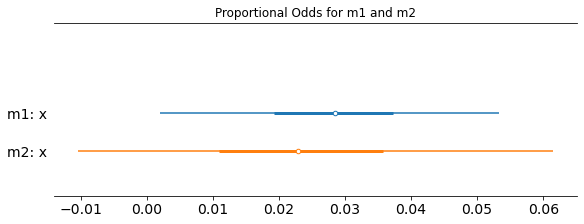

In [15]:
ax = az.plot_forest([m1_diff_p.values, m2_diff_p.values], 
              model_names=['m1', 'm2'], 
              combined=True,
              figsize=(8,3))
ax[0].set_title('Proportional Odds for m1 and m2')

By contrasting models 1 and 2 Proportional Odds we conclude that model 2, that includes the disciplines, slightly decreased the difference of gender, but also increased it's uncertainty, even overlapping 0. 

In [16]:
df['m2_pred'] = m2_post_pred['awards'].mean(0)

[]

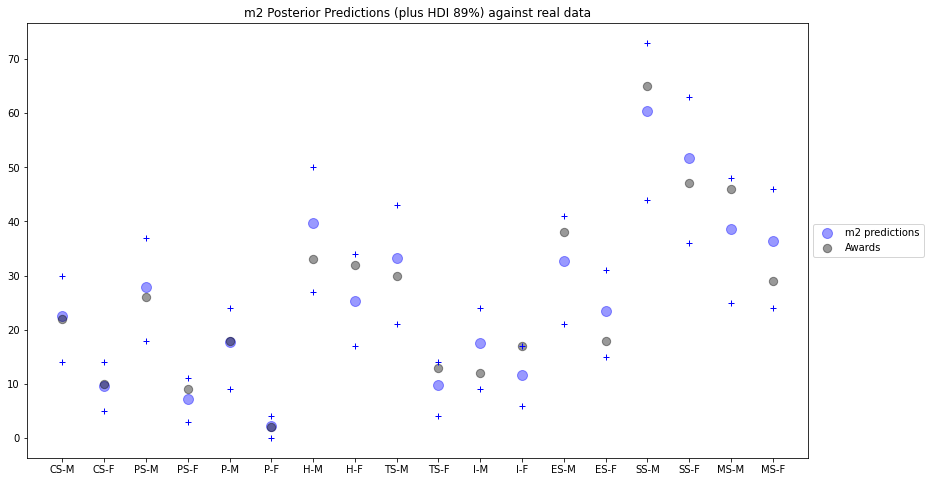

In [17]:
x_axis = np.linspace(0, 17, 18)

_, ax = plt.subplots(figsize=(14,8))
ax.scatter(x_axis, df.m2_pred, c='b', s=100, alpha=0.4, label='m2 predictions')
ax.scatter(x_axis, df.awards, c='k', s=70, alpha=0.4, label='Awards')
ax.plot([range(0,18), range(0,18)], az.hdi(m2_post_pred['awards'], hdi_prob=.89).T, 'b+')

plt.title('m2 Posterior Predictions (plus HDI 89%) against real data')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

ax.set_xticks(x_axis) 
ax.set_xticklabels(('CS-M', 'CS-F', 'PS-M', 'PS-F', 'P-M', 'P-F', 'H-M', 'H-F', 
                    'TS-M', 'TS-F', 'I-M', 'I-F', 'ES-M', 'ES-F', 'SS-M', 'SS-F', 
                    'MS-M', 'MS-F'))
plt.plot()

We have now better predictions for the majority of departments, as compared to the first model the preditions are closer to the real data. Besides, all real data points are within the 89% **High Density Interval** (HDI) of the predictions, represented bounded by the "+".
<br>
<br>
Let's compare from another perspective through a posterior prediction plot. In this type of plot the x axis is the data and the y axis the predictions. If we plot data against data we should have the dashed line in the middle.

[]

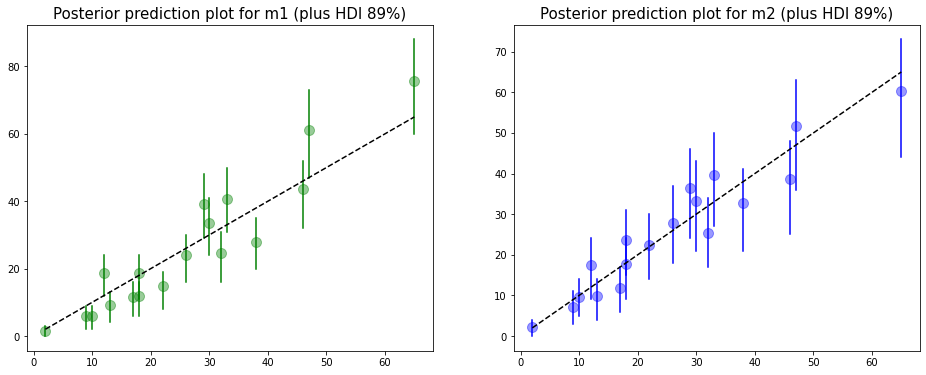

In [18]:
_, ax = plt.subplots(1, 2, figsize=(16,6))

x_min, x_max = df.awards.min(), df.awards.max()

ax[0].scatter(df.awards, df.m1_pred, c='g', s=100, alpha=0.4, label='m2 predictions')
ax[0].plot([df.awards, df.awards], az.hdi(m1_post_pred['awards'], hdi_prob=.89).T, c='g')
ax[0].plot([x_min, x_max], [x_min, x_max], "k--")
ax[0].set_title('Posterior prediction plot for m1 (plus HDI 89%)', size=15)


ax[1].scatter(df.awards, df.m2_pred, c='b', s=100, alpha=0.4, label='m2 predictions')
ax[1].plot([df.awards, df.awards], az.hdi(m2_post_pred['awards'], hdi_prob=.89).T, c='b')
ax[1].plot([x_min, x_max], [x_min, x_max], "k--")
ax[1].set_title('Posterior prediction plot for m2 (plus HDI 89%)', size=15)

plt.plot()

The standard deviations increased as there're more ways to combine **a** and **b** that match the data. 
<br>
<br>
Now it's worth to check the rate of applications across disciplines.

In [19]:
pg = pd.DataFrame(index=['male', 'female'], columns=df.discipline.sort_values().unique())

disc_grp = df.groupby('discipline')

for disc in df.discipline.unique():
    pg[disc] = (disc_grp.get_group(disc)['applications']*100/disc_grp.get_group(disc)['applications'].sum()).round(2).values
    
pg

,Chemical sciences,Earth/life sciences,Humanities,Interdisciplinary,Medical sciences,Physical sciences,Physics,Social sciences,Technical sciences
male,68.03,55.32,58.08,57.38,48.51,77.59,88.16,50.96,75.3
female,31.97,44.68,41.92,42.62,51.49,22.41,11.84,49.04,24.7


We can see that there's a great difference in the number of applications by gender for each discipline. That's why when we add discipline to the model we get a different prediction on the inference about gender.
<br>
The difference between genders quite small, especially for the last model that considers the disciplines. It's somehow balanced the influence of the discipline on being awarded by grants and the number of applicants by gender. 

The expected DAG for the causal model is the one below where G is gender, D is discipline and A is awards. 
<br>
The direct causal path is **G -> A**, however there's a backdoor (indirect path) **G->D->A**. Conditioning on D closes this indirect path.
<br>
We cannot guarantee that there're no observed confounds influencing the model.

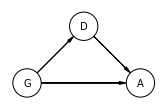

In [20]:
dag_m = CausalGraphicalModel(
    nodes=["A", "G", "D"], edges=[("G", "A"), ("D", "A"), ("G", "D")]
)

pgm = daft.PGM()
coordinates = {"G":(0, 0), "D":(1, 1), "A":(2, 0)}

for node in dag_m.dag.nodes:
    pgm.add_node(node, node, *coordinates[node])
for edge in dag_m.dag.edges:
    pgm.add_edge(*edge)
pgm.render();

---

## Effects of gender on grant awards
_"Suppose that the NWO Grants sample has an unobserved confound that influences both choice of discipline and the probability of an award. One example of such a confound could be the career stage of each applicant. Suppose that in some disciplines, junior scholars apply for most of the grants. In other disciplines, scholars from all career stages compete. As a result, career stage influences discipline as well as probability of being awarded a grant."_

Below follows the expected DAG for the causal model described where **G** is gender, **D** is discipline, **A** is awards, and **C** is career stage. 
<br>
The direct causal path is **G -> A**, however there're two backdoors (indirect path) **G->D->A** and **G->D<-C->A**.

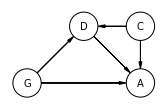

In [21]:
dag_m = CausalGraphicalModel(
    nodes=["A", "G", "D", "C"], edges=[("G", "A"), ("D", "A"), ("G", "D"),
                                       ("C", "D"), ("C", "A")]
)

pgm = daft.PGM()
coordinates = {"G":(0, 0), "D":(1, 1), "A":(2, 0), "C":(2, 1)}

for node in dag_m.dag.nodes:
    pgm.add_node(node, node, *coordinates[node])
for edge in dag_m.dag.edges:
    pgm.add_edge(*edge)
pgm.render();

_"What happens now when you condition on discipline? Does it provide an un-confounded estimate of the direct path from gender to an award? Why or why not? Justify your answer with the back-door criterion."_

When you condition on discipline **D** you open the collider **G->D<-C**, this way we open the backdoor path **G->D<-C->A**.
<br>
For this DAG is not possible to have an un-confounded estimate of the direct path from **G** (gender) to **A** (award).

Simulating some fake data to confirm the conclusion.
<br>
We'll use binary data to make it simple to simulate.

In [22]:
SAMP_SIZE = 1000
np.random.seed(89)

pGD = 1
pGA = 1
pDA = 1
pCA = 1
pCD = 1

G = np.random.binomial(n=1, p=0.5, size=SAMP_SIZE)
C = np.random.binomial(n=1, p=0.5, size=SAMP_SIZE)

D = np.random.binomial(n=1, p=logistic(pGD*G + 0.7*pCD*C))
A = np.random.binomial(n=1, p=logistic(0.3*pGA*G + 0.45*pCA*C + pDA*D))

d = pd.DataFrame.from_dict({"A":A, "C":C, "D":D, "G":G})

In [23]:
with pm.Model() as m3:
    a = pm.Normal('a', 0, 1)
    bG = pm.Normal('bG', 0, 1.5)
    bD = pm.Normal('bD', 0, 1.5)
    
    lamb = pm.math.invlogit(a + bG*d.G + bD*d.D)
    A = pm.Binomial('A', n=1, p=lamb, observed=d.A)
    
    m3_trace = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [bD, bG, a]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.


In [24]:
az.summary(m3_trace, kind='stats', round_to=2)

,mean,sd,hdi_3%,hdi_97%
a,0.04,0.12,-0.18,0.28
bG,0.58,0.16,0.31,0.89
bD,1.13,0.15,0.85,1.42


By the results we can notice that even the predicted coeficient for gender (1) is almost the double (**bG = 0.58**) of the real influence.

In [25]:
pGD = 1
pGA = 0
pDA = 1
pCA = 1
pCD = 1

G = np.random.binomial(n=1, p=0.5, size=SAMP_SIZE)
C = np.random.binomial(n=1, p=0.5, size=SAMP_SIZE)

D = np.random.binomial(n=1, p=logistic(pGD*G + 0.7*pCD*C))
A = np.random.binomial(n=1, p=logistic(0.3*pGA*G + 0.45*pCA*C + pDA*D))

d = pd.DataFrame.from_dict({"A":A, "C":C, "D":D, "G":G})

In [26]:
with pm.Model() as m4:
    a = pm.Normal('a', 0, 1)
    bG = pm.Normal('bG', 0, 1.5)
    bD = pm.Normal('bD', 0, 1.5)
    
    lamb = pm.math.invlogit(a + bG*d.G + bD*d.D)
    A = pm.Binomial('A', n=1, p=lamb, observed=d.A)
    
    m4_trace = pm.sample(tune=2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [bD, bG, a]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 5 seconds.


In [27]:
az.summary(m4_trace, kind='stats', round_to=2)

,mean,sd,hdi_3%,hdi_97%
a,0.02,0.13,-0.23,0.24
bG,0.26,0.15,-0.00,0.55
bD,1.03,0.15,0.76,1.32


Now we remove all the influence of gender over awards (**pGA = 0**), however we still get a result that shows that gender plays a role in awards granted (**bG = 0.26**). 

In [28]:
pGD = 1
pGA = 0
pDA = 1
pCA = 0
pCD = 0

G = np.random.binomial(n=1, p=0.5, size=SAMP_SIZE)
C = np.random.binomial(n=1, p=0.5, size=SAMP_SIZE)

D = np.random.binomial(n=1, p=logistic(pGD*G + 0.7*pCD*C))
A = np.random.binomial(n=1, p=logistic(0.3*pGA*G + 0.45*pCA*C + pDA*D))

d = pd.DataFrame.from_dict({"A":A, "C":C, "D":D, "G":G})

In [29]:
with pm.Model() as m5:
    a = pm.Normal('a', 0, 1)
    bG = pm.Normal('bG', 0, 1.5)
    bD = pm.Normal('bD', 0, 1.5)
    
    lamb = pm.math.invlogit(a + bG*d.G + bD*d.D)
    A = pm.Binomial('A', n=1, p=lamb, observed=d.A)
    
    m5_trace = pm.sample(tune=2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [bD, bG, a]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 5 seconds.


In [30]:
az.summary(m5_trace, kind='stats', round_to=2)

,mean,sd,hdi_3%,hdi_97%
a,0.11,0.12,-0.11,0.33
bG,-0.11,0.15,-0.38,0.17
bD,1.04,0.15,0.76,1.32


Testing is never to much, so we just removed career stage **C** from the data, as well as it's influences. Furthermore, we removed the gender confounding granted awards. As expected when we run the same inference **bG** is around 0.

---

## Working with the 'primates' dataset
_"In this problem, you will consider how brain size is associated with social learning. There are three parts.
<br>
First, model the number of observations of social_learning for each species as a function of the logbrain size. Use a Poisson distribution for the social_learning outcome variable. Interpret the resulting posterior."_

In [31]:
df = pd.read_csv('../data/Primates301.csv', sep=';')
df.dropna(subset=['species', 'social_learning', 'brain', 'research_effort'], inplace=True)
df.head()

,name,genus,species,subspecies,spp_id,genus_id,social_learning,research_effort,brain,body,group_size,gestation,weaning,longevity,sex_maturity,maternal_investment
0,Allenopithecus_nigroviridis,Allenopithecus,nigroviridis,NaN,1,1,0.0,6.0,58.02,4655.0,40.0,NaN,106.15,276.0,NaN,NaN
2,Alouatta_belzebul,Alouatta,belzebul,NaN,3,3,0.0,15.0,52.84,6395.0,7.4,NaN,NaN,NaN,NaN,NaN
3,Alouatta_caraya,Alouatta,caraya,NaN,4,3,0.0,45.0,52.63,5383.0,8.9,185.92,323.16,243.6,1276.72,509.08
4,Alouatta_guariba,Alouatta,guariba,NaN,5,3,0.0,37.0,51.70,5175.0,7.4,NaN,NaN,NaN,NaN,NaN
5,Alouatta_palliata,Alouatta,palliata,NaN,6,3,3.0,79.0,49.88,6250.0,13.1,185.42,495.60,300.0,1578.42,681.02


In [32]:
def standardize(series):
    return (series - series.mean())/series.std()

In [33]:
d = pd.DataFrame()
d['genus'] = df['genus']
d['species'] = df['species']
d['species_id'] = df['species'].astype('category').cat.codes
d['brain_log'] = standardize(np.log(df['brain']))
d['social_learning'] = df['social_learning']
d['research_effort'] = df['research_effort']

In [34]:
# necessary for the posterior plot
d.sort_values('species_id', inplace=True)
d

,genus,species,species_id,brain_log,social_learning,research_effort
85,Chlorocebus,aethiops,0,0.445718,5.0,91.0
131,Hylobates,agilis,1,0.723314,0.0,16.0
50,Cebus,albifrons,2,0.451380,1.0,13.0
159,Lophocebus,albigena,3,0.748231,0.0,34.0
111,Galago,alleni,4,-1.569345,0.0,2.0
...,...,...,...,...,...,...
300,Varecia,variegata,140,-0.132824,0.0,57.0
256,Propithecus,verreauxi,141,-0.299710,1.0,41.0
250,Procolobus,verus,142,0.271992,0.0,3.0
298,Trachypithecus,vetulus,143,0.397483,0.0,2.0


In [35]:
with pm.Model() as m6:
    a = pm.Normal('a', 0, 1)
    bB = pm.Normal('bB', 0, 0.2)
    
    lamb = pm.math.exp(a + bB*d.brain_log)
    
    social_learning = pm.Poisson('social_learning', mu=lamb, observed=d.social_learning)
    
    m6_trace = pm.sample(tune=2000)
    m6_posterior_pred = pm.sample_posterior_predictive(m6_trace)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [bB, a]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 3 seconds.
The number of effective samples is smaller than 25% for some parameters.


In [36]:
az.summary(m6_trace, kind='stats', round_to=2)

,mean,sd,hdi_3%,hdi_97%
a,-0.78,0.10,-0.99,-0.60
bB,2.48,0.07,2.34,2.61


According to the results brain size is strongly correlated to social learning.
<br>
<br>
Let's plot the posterior predictions compared to the real data.

In [37]:
d['m6_soclearning_pred'] = m6_posterior_pred['social_learning'].mean(0)

[]

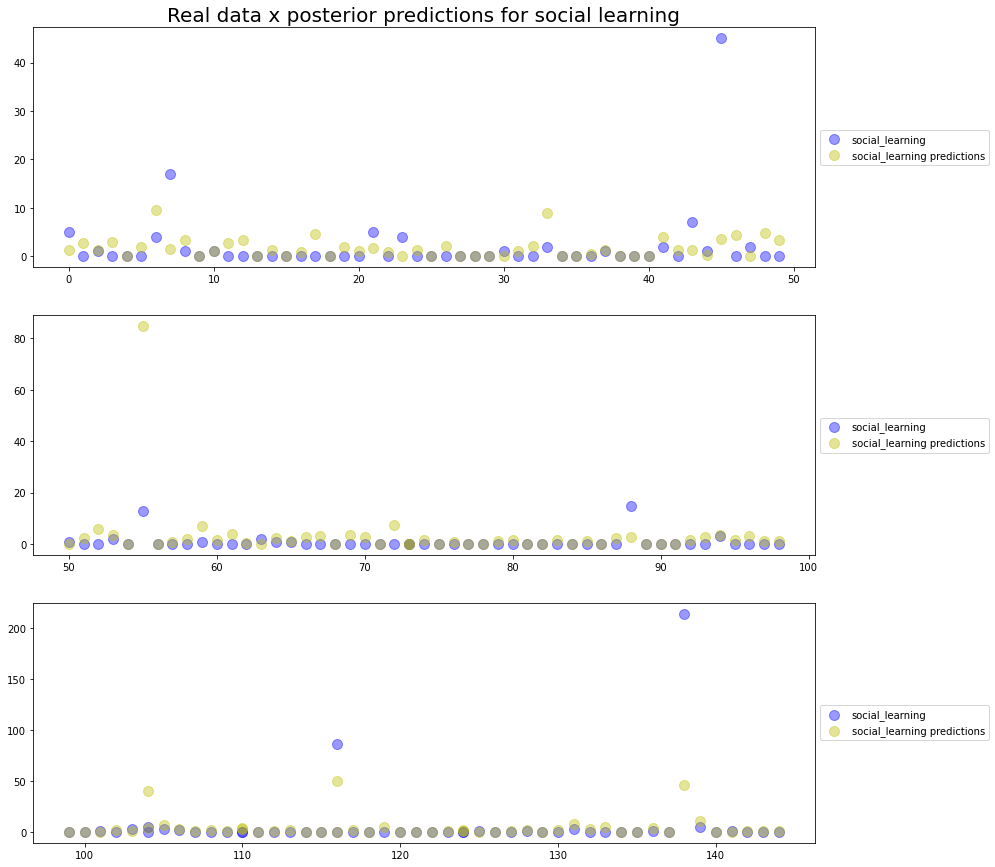

In [38]:
_, ax = plt.subplots(3, 1, figsize=(14,15))
ax[0].scatter(d.species_id[:50], d.social_learning[:50], c='b', s=100, alpha=0.4, label='social_learning')
ax[0].scatter(d.species_id[:50], d.m6_soclearning_pred[:50], c='y', s=100, alpha=0.4, label='social_learning predictions')
ax[0].legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax[0].set_title('Real data x posterior predictions for social learning', size=20)

ax[1].scatter(d.species_id[50:100], d.social_learning[50:100], c='b', s=100, alpha=0.4, label='social_learning')
ax[1].scatter(d.species_id[50:100], d.m6_soclearning_pred[50:100], c='y', s=100, alpha=0.4, label='social_learning predictions')
ax[1].legend(loc='center left', bbox_to_anchor=(1, 0.5))

ax[2].scatter(d.species_id[100:], d.social_learning[100:], c='b', s=100, alpha=0.4, label='social_learning')
ax[2].scatter(d.species_id[100:], d.m6_soclearning_pred[100:], c='y', s=100, alpha=0.4, label='social_learning predictions')
ax[2].legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.plot()

These are not bad predictions for most of the data but there're some points where the model misses too much. Definitely it's the case we should try other predictive variables to see if we can fit better our predictions.

---
_"Some species are studied much more than others. So the number of reported instances of social_learning could be a product of research effort. Use the research_effort variable, specifically its logarithm, as an additional predictor variable. Interpret the coefficient for log research_effort. Does this model disagree with the previous one?"_

In [39]:
d['research_eff_log'] = np.log(df['research_effort'])

In [40]:
with pm.Model() as m7:
    a = pm.Normal('a', 0, 1)
    bB = pm.Normal('bB', 0, 0.2)
    bR = pm.Normal('bR', 0, 0.2)
    
    lamb = pm.math.exp(a + bB*d.brain_log + bR*d.research_eff_log)
    
    social_learning = pm.Poisson('social_learning', mu=lamb, observed=d.social_learning)
    
    m7_trace = pm.sample(tune=2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [bR, bB, a]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 6 seconds.
The acceptance probability does not match the target. It is 0.8857626899896633, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


In [41]:
az.summary(m7_trace, kind='stats', round_to=2)

,mean,sd,hdi_3%,hdi_97%
a,-5.53,0.28,-6.03,-5.01
bB,0.50,0.08,0.36,0.65
bR,1.44,0.06,1.33,1.55


This model shows that research_effort variable plays a big role on social learning. Besides by adding research_effort in the model influency of the brain size variable over social learning reduced significantly.

In [42]:
az.compare({'m6': m6_trace, 'm7': m7_trace}, ic='loo', scale='deviance')

/home/elisio/anaconda3/lib/python3.8/site-packages/arviz/stats/stats.py:683: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/home/elisio/anaconda3/lib/python3.8/site-packages/arviz/stats/stats.py:683: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


,rank,loo,p_loo,d_loo,weight,se,dse,warning,loo_scale
m7,0,564.616,48.7783,0,1,465.975,0,True,deviance
m6,1,1360.83,94.9119,796.209,2.89484e-51,171.399,358.03,True,deviance


According to the results of comparison of models, using leave-one-out cross-validation PSIS method, the model that includes **research_effort** is more reliable to make predictions.
<br>
<br>
However, both models show warnings about high values of Pareto distribution for some points. It means that the smoothing approximation that PSIS uses is unreliable for some points.
<br>
"Furthermore, these points tend to be outliers with unlikely
values, according to the model. As a result, they are highly influential and make it difficult to estimate out-of-sample predictive accuracy. Why? Because any new sample is unlikely to contain these same outliers, and since these outliers were highly influential, they could make out-of-sample predictions worse than expected."

Let's compute the array of pointwise predictive accuracy for both models and compare. We're doing with PSIS-LOO but we could have used WAIC as well.
<br>
By using the **deviance** scale, the smaller values are better

In [43]:
m6_loo = az.loo(m6_trace, pointwise=True, scale='deviance')
m7_loo = az.loo(m7_trace, pointwise=True, scale='deviance')

# because of the deviance scale we subtract in the following order
d['diff_loo'] = m6_loo.loo_i - m7_loo.loo_i

/home/elisio/anaconda3/lib/python3.8/site-packages/arviz/stats/stats.py:683: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/home/elisio/anaconda3/lib/python3.8/site-packages/arviz/stats/stats.py:683: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


Text(0, 0.5, 'research effort log')

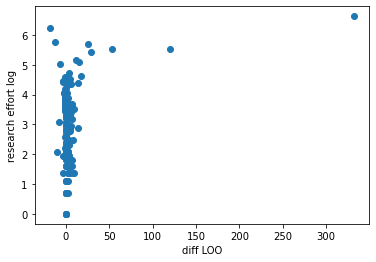

In [47]:
plt.scatter(d['diff_loo'], d['research_eff_log'])
plt.xlabel('diff LOO')
plt.ylabel('research effort log')

The plot above shows the difference in accuracy of predictions between models m7 and m6.
<br>
The righest points are better predicted by model m7, that includes **research_effort**. And it shows how research effort influences predictions.

---
_"Draw a DAG to represent how you think the variables social_learning, brain and research_effort interact. Justify the DAG with measured associations in the two models above."_

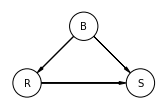

In [45]:
dag_m = CausalGraphicalModel(
    nodes=["R", "B", "S"], edges=[("B", "R"), ("B", "S"), ("R", "S")]
)

pgm = daft.PGM()
coordinates = {"R":(0, 0), "B":(1, 1), "S":(2, 0)}

for node in dag_m.dag.nodes:
    pgm.add_node(node, node, *coordinates[node])
for edge in dag_m.dag.edges:
    pgm.add_edge(*edge)
pgm.render();

* R -> research effort
* B -> brain size
* S -> social learning
<br>
<br>
By the second model it's clear that research effort has a influence over social learning, that can mean the more a given species is studied the more is known about their social learning. At the same time brain size influences research effort as researchers are more interested on species that can show more intelligence and also influces social learning.  

---
---

In [46]:
%load_ext watermark
%watermark -iv -v -nuw

Last updated: Thu Feb 18 2021

Python implementation: CPython
Python version       : 3.8.5
IPython version      : 7.19.0

pymc3     : 3.9.3
matplotlib: 3.3.2
arviz     : 0.10.0
daft      : 0.1.0
seaborn   : 0.11.0
scipy     : 1.5.2
numpy     : 1.19.2
pandas    : 1.1.3

Watermark: 2.1.0

